# Pregunta 6

(2 puntos) La imagen Ex3Preg6(a).tif muestra una imagen tomada con un microscopio de cultivo de bacterias identificadas por los círculos intensos:

a. (0.5 puntos) Usando una técnica de umbralización global, segmente la imagen y muestre el resultado de la segmetnación.

b. (0.5 puntos) A la imagenoriginal se le aplicó una umbralización con valores locales yal resultado se le realizó una apertura morbológica obteniendo la imagen Ex3Preg6(b).tif. Usando esta imagen,cuente y etiquete cuantos objetos de la segmentación pueden considerarse células independientes. 

c. (1 punto) Continuando con la imagen anterior. Cuente y etiquete cuantos objetos de la segmentación pueden considerarse 2 células agrupadas, y cuantos y cuales más de 2 células.

In [35]:
# Functional programing tools : 
from functools import partial, reduce

# Visualisation : 
import matplotlib.pyplot as plt
import matplotlib.image as pim
import seaborn as sns

# Data tools :
import numpy as np
import pandas as pd

# Image processing : 
import cv2 as cv

# Machine Learning :
from sklearn.cluster import KMeans

# Custom :
from mfilt_funcs import *
from utils import *

In [34]:
#plt.style.available

In [21]:
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (12, 7)

In [22]:
img   = cv.imread('imagenes/Ex3Preg6(a).tif', cv.IMREAD_GRAYSCALE)
color = cv.cvtColor(img, cv.COLOR_GRAY2RGB) # Color copy, to draw colored circles
img2  = img.copy() # Another copy

a. (0.5 puntos) Usando una técnica de umbralización global, segmente la imagen y muestre el resultado de la segmetnación.

In [ ]:
intensity = pd.core.frame.DataFrame(dict(intensity=img.flatten()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24063350>]],
      dtype=object)

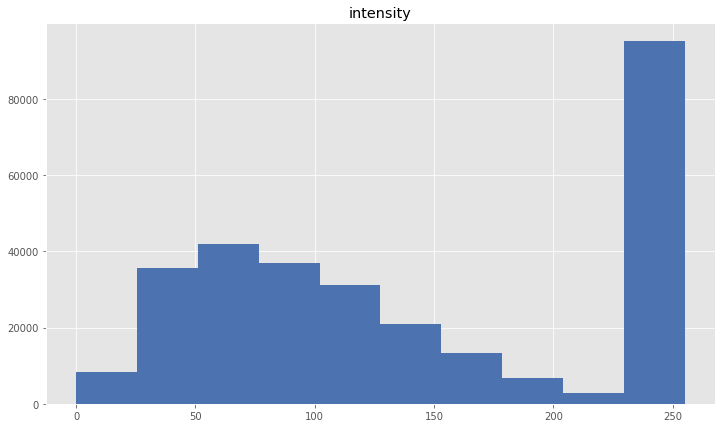

In [33]:
intensity.hist()

In [41]:
kmeans = KMeans(n_clusters=2, random_state=0, verbose=False).fit(intensity)

In [42]:
img[kmeans.labels_]

TypeError: 'module' object is not subscriptable

In [33]:
# Blur the image to reduce noise
img_blur = cv.medianBlur(img, 5)

In [34]:
# Apply hough transform on the image
circles = cv.HoughCircles(img_blur, cv.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=5, maxRadius=7)

In [35]:
# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw outer circle
        cv.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Draw inner circle
        #cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3)

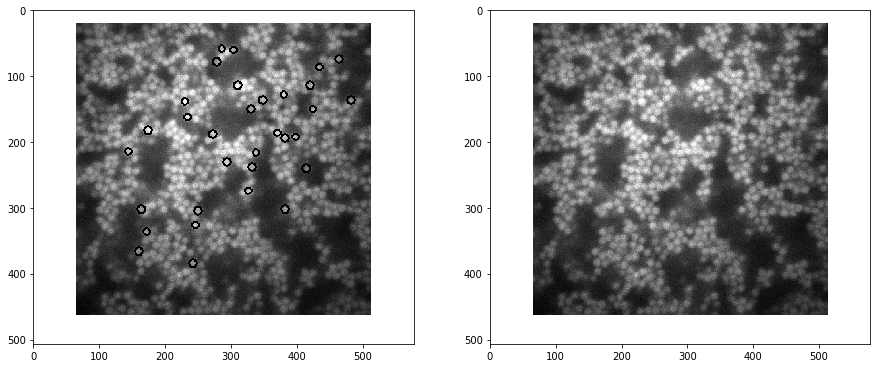

In [36]:
side_by_side(img, color)

In [28]:
help(cv2.HoughCircles)

Help on built-in function HoughCircles:

HoughCircles(...)
    HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
    .   @brief Finds circles in a grayscale image using the Hough transform.
    .   
    .   The function finds circles in a grayscale image using a modification of the Hough transform.
    .   
    .   Example: :
    .   @include snippets/imgproc_HoughLinesCircles.cpp
    .   
    .   @note Usually the function detects the centers of circles well. However, it may fail to find correct
    .   radii. You can assist to the function by specifying the radius range ( minRadius and maxRadius ) if
    .   you know it. Or, you may set maxRadius to a negative number to return centers only without radius
    .   search, and find the correct radius using an additional procedure.
    .   
    .   @param image 8-bit, single-channel, grayscale input image.
    .   @param circles Output vector of found circles. Each vector is enco

In [26]:
help(cv2.cvtColor)

Help on built-in function cvtColor:

cvtColor(...)
    cvtColor(src, code[, dst[, dstCn]]) -> dst
    .   @brief Converts an image from one color space to another.
    .   
    .   The function converts an input image from one color space to another. In case of a transformation
    .   to-from RGB color space, the order of the channels should be specified explicitly (RGB or BGR). Note
    .   that the default color format in OpenCV is often referred to as RGB but it is actually BGR (the
    .   bytes are reversed). So the first byte in a standard (24-bit) color image will be an 8-bit Blue
    .   component, the second byte will be Green, and the third byte will be Red. The fourth, fifth, and
    .   sixth bytes would then be the second pixel (Blue, then Green, then Red), and so on.
    .   
    .   The conventional ranges for R, G, and B channel values are:
    .   -   0 to 255 for CV_8U images
    .   -   0 to 65535 for CV_16U images
    .   -   0 to 1 for CV_32F images
    .   
    .